In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.regularizers import l2, l1

In [13]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

**Set Training Path**

In [14]:
data_dir = 'extracted_images'
batch_size = 32
img_height = 45
img_width = 45

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=binarize)

In [16]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123)

Found 83933 images belonging to 24 classes.


In [17]:
class_names = [k for k,v in train_generator.class_indices.items()]
class_names
# class_names = ['(',')','+','-','0','1','2','3','4','5','6','7','8','9','=','A','X','b','cos','div','log','sin','tan','theta','times','y','z']

['(',
 ')',
 '+',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'X',
 'cos',
 'div',
 'log',
 'sin',
 'tan',
 'times',
 'y',
 'z']

**Convolutional Neural Network**

In [18]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 45, 45, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)         

In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
  optimizer=optimizer,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy')

model.fit(
  train_generator,
  epochs=5,
  batch_size=5
  )

Epoch 1/5
2623/2623 [==============================] - 376s 142ms/step - loss: 1.8037 - accuracy: 0.7905
Epoch 2/5
2623/2623 [==============================] - 161s 61ms/step - loss: 0.9411 - accuracy: 0.8736
Epoch 3/5
2623/2623 [==============================] - 116s 44ms/step - loss: 0.8695 - accuracy: 0.8855
Epoch 4/5
2623/2623 [==============================] - 114s 43ms/step - loss: 0.8344 - accuracy: 0.8909
Epoch 5/5
2623/2623 [==============================] - 112s 43ms/step - loss: 0.8063 - accuracy: 0.8961


In [23]:
model.save('eqn-detect18-model')

INFO:tensorflow:Assets written to: eqn-detect18-model\assets


INFO:tensorflow:Assets written to: eqn-detect18-model\assets


In [24]:
image_dir = "equation_images/"

In [25]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 20: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [26]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [27]:
# Load model
new_model = tf.keras.models.load_model('eqn-detect18-model', compile=False)

6


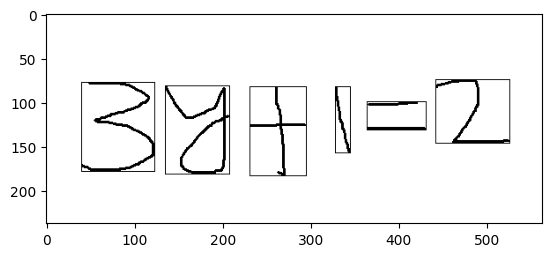

In [28]:
flag = 0
IMAGE = "lineareqy3.png"
img_path = "equation_images/"+IMAGE

if flag == 1:
    input_image = cv2.imread(img_path) 
    ret, bw_img = cv2.threshold(input_image,127,255,cv2.THRESH_BINARY)
    plt.imshow(bw_img)
    plt.show()
    cv2.imwrite(img_path, bw_img) 
    input_image_cpy = bw_img.copy()
    keep = detect_contours(image_dir+IMAGE)
    print(len(keep))
    img_path = image_dir+IMAGE
else:
    input_image = cv2.imread(img_path, 0) 
    input_image_cpy = input_image.copy()
    keep = detect_contours(image_dir+IMAGE)
    print(len(keep))

#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()



In [29]:
eqn_list = []

# binarize the input image
#IMAGE = "akshibig.jpg"
#img_path = "equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
inverted_binary_img = binarize(input_image)
# plt.imshow(input_image, cmap='gray')
# plt.show()
# plt.imshow(inverted_binary_img, cmap='gray')
# plt.show()

for (x, y, w, h) in sorted(keep, key = lambda x: x[0]):
    # plt.imshow(inverted_binary_img[y:y+h, x:x+w])
    # plt.show()
    img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0) # We must use the binarized image to predict
    # plt.imshow(img)
    # plt.show()
    pred_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]
    if pred_class == "times":
        pred_class = "*"
    if pred_class == "div":
        pred_class = chr(47)
    eqn_list.append(pred_class)
    print(pred_class)
    #plt.imshow(img)
    #plt.show()
eqn = "".join(eqn_list)
print(eqn)

1/1 [==============================] - 0s 152ms/step
3
1/1 [==============================] - 0s 24ms/step
y
1/1 [==============================] - 0s 21ms/step
+
1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 26ms/step
=
1/1 [==============================] - 0s 23ms/step
2
3y+1=2


In [26]:
print(eqn)

(((((


In [54]:
type(eqn)

str

In [18]:
def put_double_asterisk(s):
    # Convert the string to a list
    lst = list(s)
    i = 0
    # Iterate over the list
    while i < len(lst)-1:
        if lst[i].isalpha():
            if lst[i+1].isdigit():
                # Insert the double asterisk
                lst.insert(i+1, '**')
                i += 1
        i += 1
    # Convert the list back to a string
    s_new = ''.join(lst)
    return s_new

def put_single_asterisk(s):
    lst = list(s)
    i=0
    while i < len(lst)-1:
        if lst[i].isdigit() and lst[i+1].isalpha():
            lst.insert(i+1,'*')
        i+=1
    s_new = ''.join(lst)
    return s_new 

# we need to write a function with try and exceptions blocks 
# 

In [27]:
from sympy import *
import sympy as sym
def solve_equation(equation):
    try:
        equation = put_double_asterisk(equation)
        equation = put_single_asterisk(equation)
        # print(equation)
        # print("1")
        if 'x' in equation and '=' in equation:
            x = sym.symbols('x')
            left, right = equation.split("=")
            # print("6")
            eq = left+'-'+right
            # print('---------------')
            result = sym.solve(eq, (x))

            return result, equation
        elif 'x' in equation and '=' not in equation:
            x = sym.symbols('x')
            result = sym.solveset(equation, x)
            return result, equation
        
        elif 'y' in equation and '=' in equation:
            y = sym.symbols('y')

            left, right = equation.split("=")
            # print("6")
            eq = left+'-'+right
            # print('---------------')
            result = sym.solve(eq, (y))

            return result, equation
        elif 'y' in equation and '=' not in equation:
            y=sym.symbols('y')
            result = sym.solveset(equation,y)
            return result, equation
        
        elif 'x' in equation and 'y' in equation and '=' in equation :
            x,y = sym.symbols('x,y')

            left, right = equation.split("=")
            # print("6")
            eq = left+'-'+right
            # print('---------------')
            result = sym.solve(eq, (x,y))

            return result, equation
        
        elif '=' in equation and 'sin' in equation or 'tan' in equation or 'cos' in equation:
            if 'x' in equation and 'y' in equation:
                x,y = symbols('x,y')
                eq_sympy = sympify(equation)
                result = solve((eq_sympy), (x,y))
                return result, equation
            elif 'x' in equation:
                x = symbols('x')
                eq_sympy = sympify(equation)
                result = solve((eq_sympy), x)
                return result, equation
            elif 'y' in equation:
                y = symbols('y')
                eq_sympy = sympify(equation)
                result = solve((eq_sympy), y)
                return result, equation
            else:
                pass
        else:
            pass
        # print("2")

        if "=" not in equation:

            if 'sin' in equation or 'tan' in equation:
                eq = sympify(equation)
                result = eq.evalf()
                return result, equation
            
            # print("3")
            result = sym.simplify(equation)
            # print("4")
            # print(f"Result: {result}")
            return result, equation

        else:
            # print("5")
            left, right = equation.split("=")
            # print("6")
            # eq = left+'-'+right
            # print('---------------')
            result = sym.solve(left,right)
            # result = sym.solve(left + "-" + right, x)

            if len(result) == 0:
                # print("No solution found.")
                return "No solution found.",equation 
            else:
                # print("Solution(s):")
                return result, equation

    except (ValueError, TypeError, AttributeError, RuntimeError, SyntaxError) as e:
        # print(f"Error: {e}")
        return str('Wrong equation prediction'), equation

In [20]:
# Example usage:
# Solve a linear equation: 2x + 1 = 0
# solve_equation('2*x + 1')

# Solve a quadratic equation: x^2 + 2x + 1 = 0
# solve_equation('x**2 + 2*x + 1')

# Evaluate an arithmetic expression: 2 + 3 * 4 - 1
# solve_equation('2 + 3 * 4 - 1')

# Solve an arithmetic equation: x + 2 = 5
# solve_equation('x + 2 = 5')

solve_equation('9y3+3y+1')

('Wrong equation prediction', '9*y**3+3*y+1')

In [28]:
y = sym.symbols('y')
eq = 3*y+1

solution = sym.solveset(eq, y)

In [29]:
solution

{-1/3}